In [1]:
from pathlib import Path
import numpy as np
import torch
import cv2
import albumentations as A
import wandb
import copy

from model import transfer_model, eff_model
from image_utils import *
from datasets import *
from dataloader import config, train_loader, val_loader, test_loader
%reload_ext autoreload
%autoreload 2

c:\Users\trvexe\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained weights for efficientnet-b5


# Load Data

In [2]:
DATASET_DIR = Path('train')
CONFIG_FILENAME = 'conf/train_preprocessing.yaml'
dataset = ImageDirsDataset(images_dir=DATASET_DIR, preprocessing_config=CONFIG_FILENAME)
print(f'length train dataset={len(dataset)}')

DATASET_VAL_DIR = Path('val')
CONFIG_VAL_FILENAME = 'conf/val_preprocessing.yaml'
dataset_val = ImageDirsDataset(images_dir=DATASET_VAL_DIR, preprocessing_config=CONFIG_VAL_FILENAME)
print(f'length val dataset={len(dataset_val)}')

DATASET_TEST_DIR = Path('test')
CONFIG_TEST_FILENAME = 'conf/val_preprocessing.yaml'
dataset_test = ImageDirsDataset(images_dir=DATASET_TEST_DIR, preprocessing_config=CONFIG_TEST_FILENAME)
print(f'length test dataset={len(dataset_test)}')

length train dataset=15000
length val dataset=5000
length test dataset=5000


In [3]:
config.dataset

DatasetSettings(train_path=WindowsPath('train'), val_path=WindowsPath('val'), test_path=WindowsPath('test'), train_preprocessing_config=WindowsPath('conf/train_preprocessing.yaml'), val_preprocessing_config=WindowsPath('conf/val_preprocessing.yaml'), loader_num_workers=2, train_size=0.6, batch_size=128)

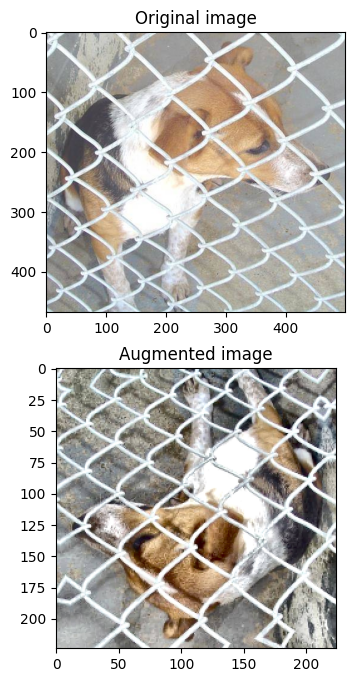

In [4]:
idx = np.random.randint(0, len(dataset))
sample = dataset[idx]

# Train

In [6]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trvexe. Use `wandb login --relogin` to force relogin


True

In [7]:
config_wdb = dict(
    epochs=10,
    classes=2,
    batch_size=train_loader.batch_size,
    learning_rate=0.001,
    dataset="cats-vs-dogs",
    architecture="densenet201")

In [5]:
from model import transfer_model, base_cnn_model, resnet
from train import train_model, evaluate
import torch.optim as optim
from torch.nn import BCELoss

In [22]:
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
with wandb.init(project="demo-run-2", config=config_wdb):
      config = wandb.config
      best_model_wts, train_loss_history, train_f1_history, val_loss_history, val_f1_history = train_model(transfer_model, optimizer, BCELoss(), train_loader, val_loader, device, config)

In [18]:
torch.save(best_model_wts.state_dict(), 'correct_models/resnet_stock.pth')

In [15]:
upl_model = copy.deepcopy(transfer_model)
upl_model.load_state_dict(torch.load('correct_models/densenet_3unfrozen_layers.pth'))
upl_model = upl_model.to(device)

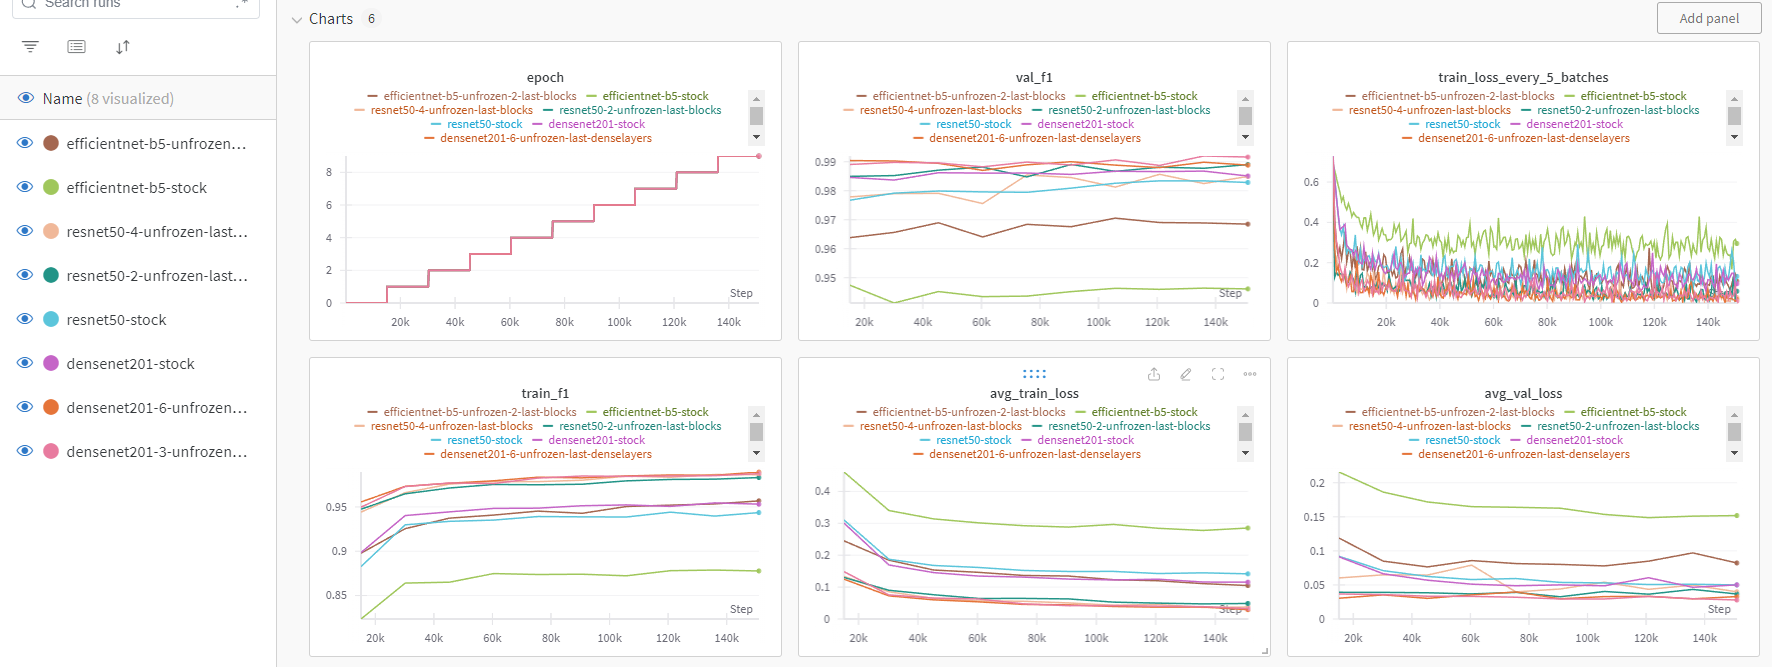

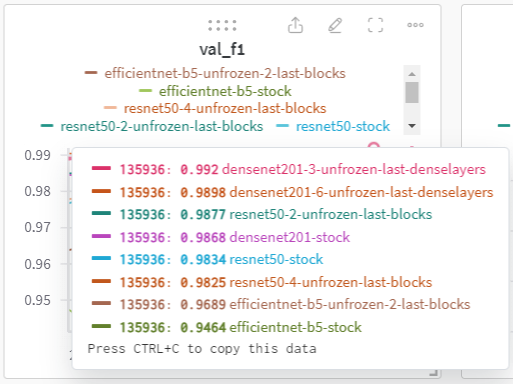

Исходя из результатов на валидации, лучшей моделью оказалась densenet201 c тремя размороженными последними группами слоёв в последнем денсблоке

# Test + confusion matrix on test,  confusion matrix on validation

100%|██████████| 40/40 [01:23<00:00,  2.08s/it]


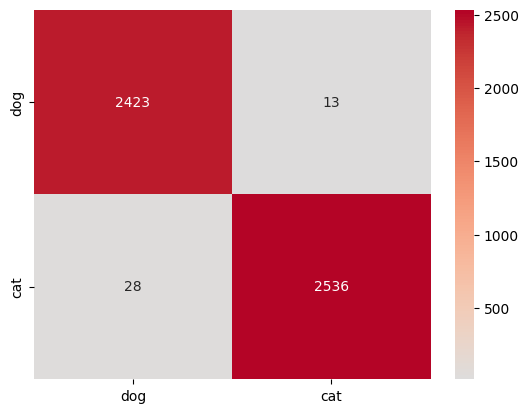

f1 on test data: 0.9920


In [16]:
from test import test_model

test_f1 = test_model(upl_model, val_loader, device)

Итоговое значение f1 на валидационной части данных = 0.9920

100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


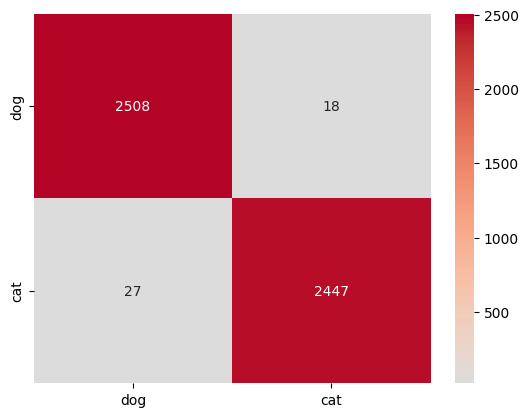

f1 on test data: 0.9909


In [17]:
from test import test_model

test_f1 = test_model(upl_model, test_loader, device)

Итоговое значение f1 на тестовой части данных = 0.9909

# Predict

## Резлуьтаты работы модели

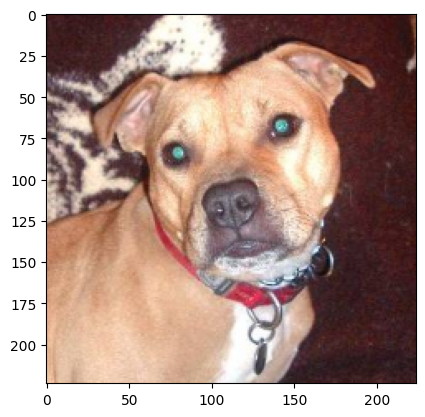

Predicted class for photo 1: 0.0 - dog


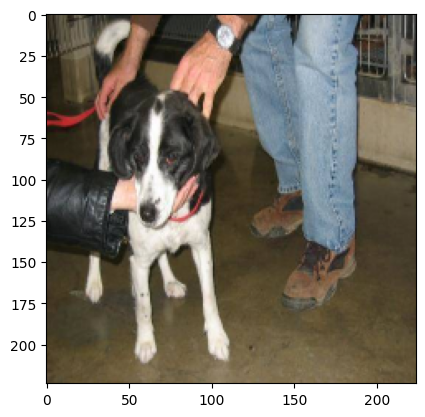

Predicted class for photo 2: 0.0 - dog


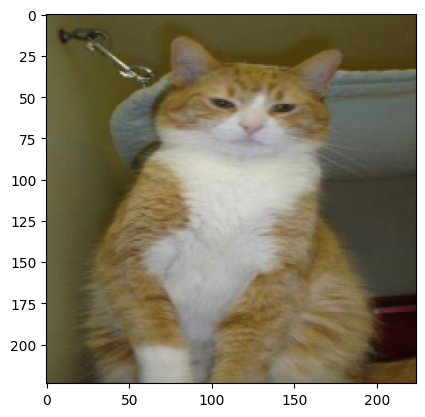

Predicted class for photo 3: 1.0 - cat


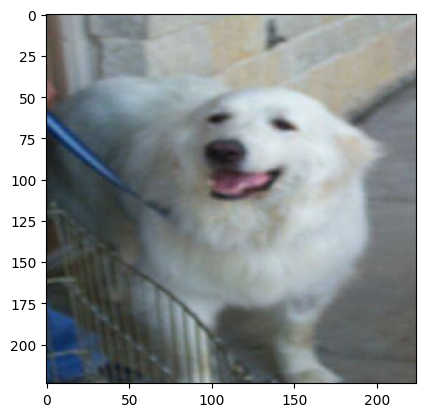

Predicted class for photo 4: 0.0 - dog


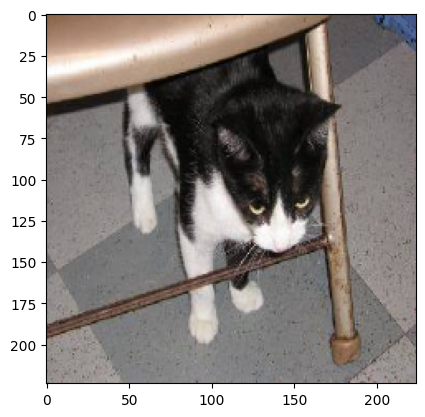

Predicted class for photo 5: 1.0 - cat


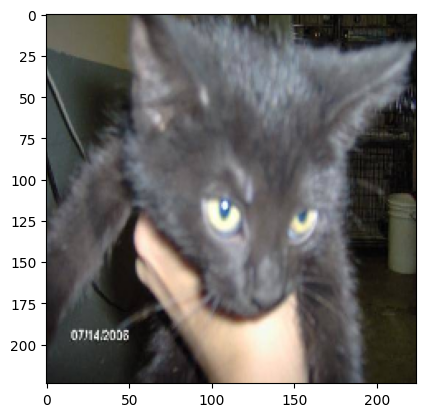

Predicted class for photo 6: 1.0 - cat


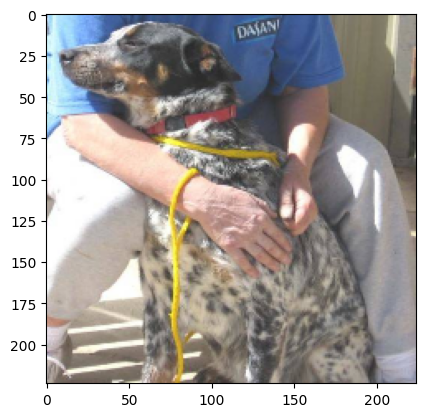

Predicted class for photo 7: 0.0 - dog


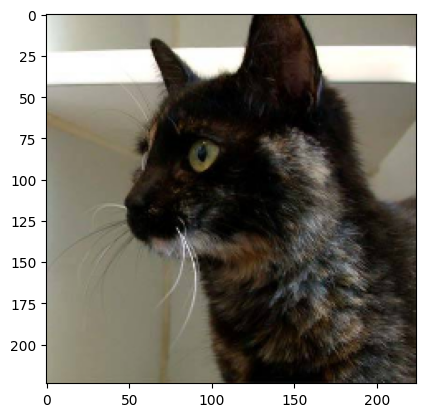

Predicted class for photo 8: 1.0 - cat


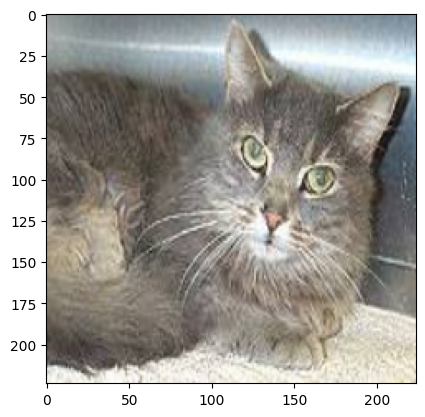

Predicted class for photo 9: 1.0 - cat


In [11]:
from predict import *

images = get_img_names('some_photos_for_test')
predicted = predict_img_class(upl_model, images, device)
show_predicted(images, predicted)

## Создание submission по обработанным данным

In [12]:
df = make_submission_csv(images, predicted, "submission.csv")
df

Saved submission.csv


,img_names,class
0,some_photos_for_test\2.jpg,0.0
1,some_photos_for_test\289.jpg,0.0
2,some_photos_for_test\290.jpg,1.0
3,some_photos_for_test\292.jpg,0.0
4,some_photos_for_test\294.jpg,1.0
5,some_photos_for_test\302.jpg,1.0
6,some_photos_for_test\326.jpg,0.0
7,some_photos_for_test\5.jpg,1.0
8,some_photos_for_test\7.jpg,1.0
